### Importing Libraries

In [1]:
!pip install tensorflow-io

In [2]:
import os 
import random 
import shutil 
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd 
import tensorflow as tf  

from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras import layers 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model 
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, classification_report, RocCurveDisplay

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## EDA

### *Load Data*

In [3]:
# path to the dataset
data = "/kaggle/input/garden-dataset1"
   
# List of all classes in the dataset directory
classes = os.listdir(data) 
print("Classes: {}".format(classes))

# Set the test split ratio
test_split = 0.2
 
# Create separate directories for the training and test sets
# the train directory
train_dir = 'training'
shutil.rmtree('training', ignore_errors=True) 
os.mkdir('training') 

# the test directory
test_dir = 'testing'
shutil.rmtree('testing', ignore_errors=True) 
os.mkdir('testing')  
# Split the data into training and validation sets
for class_name in classes:
    class_dir = os.path.join(data, class_name)
    train_class_dir = os.path.join(train_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(test_class_dir, exist_ok=True)

    # Get the list of images in the class directory
    images = os.listdir(class_dir)
    num_images = len(images)
    num_test = int(test_split * num_images)

    # Move images to the training directory
    for img in images[:-num_test]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(train_class_dir, img)
        shutil.copy(src_path, dst_path)
        
        # Move images to the test directory
    for img in images[-num_test:]:
        src_path = os.path.join(class_dir, img)
        dst_path = os.path.join(test_class_dir, img)
        shutil.copy(src_path, dst_path)

Classes: ['Cassava', 'Grass', 'Maize', 'Sugarcane']


In [4]:
# Set the paths to the train, val, and test directories
train_data = "training"
test_data = "testing"

# Set the image size and batch size for training and validation data
img_size = (224, 224)
batch_size = 32

# Create ImageDataGenerators for the training and val sets
def split_train_val(subset): 
    print('get_dataset:', subset)
    return tf.keras.utils.image_dataset_from_directory(
    train_data,
    validation_split=0.15,
    subset=subset,
    seed=42,
    label_mode='categorical',    
    image_size=img_size,
    batch_size=batch_size)

train_generator = split_train_val("training") 

val_generator = split_train_val("validation")


# Load test Images
print('Test set')
test_generator = tf.keras.utils.image_dataset_from_directory(
    test_data,  
    label_mode='categorical',
    image_size=img_size,
    batch_size=batch_size)

# Classes in the dataset 
class_names = train_generator.class_names
print("Class names: {}".format(class_names)) 

# Convert one-hot encoded labels to class indices
class_indices = {i: class_name for i, class_name in enumerate(class_names)}

get_dataset: training
Found 737 files belonging to 4 classes.
Using 627 files for training.
get_dataset: validation
Found 737 files belonging to 4 classes.
Using 110 files for validation.
Test set
Found 183 files belonging to 4 classes.
Class names: ['Cassava', 'Grass', 'Maize', 'Sugarcane']


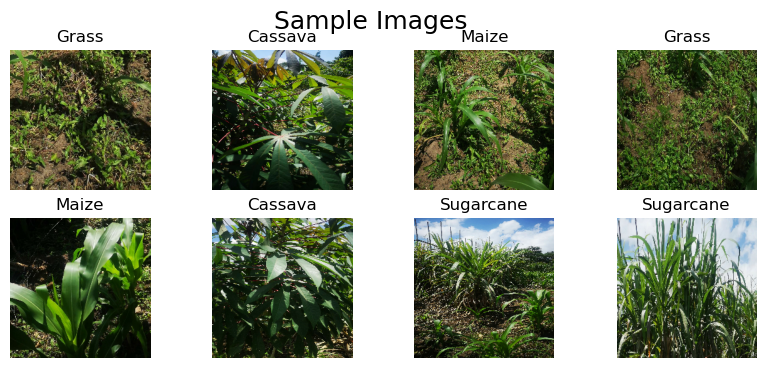

In [5]:
# Plot some sample images from the training set
plt.figure(figsize=(10, 4))
plt.suptitle('Sample Images', fontsize=18)   

class_counts = {class_name: 0 for class_name in class_names}
target_count = 2  # Number of images to plot from each class
subplot_idx = 1
for images, labels in train_generator: 
    for i in range(len(images)): 
        # Convert one-hot encoded label to class index
        label_index =  tf.argmax(labels[i]).numpy()
        class_label = class_indices[label_index]     
        # Plot the image only if we haven't reached the target count for the class
        
        if class_counts[class_label] < target_count:
            ax = plt.subplot(2, 4, subplot_idx)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_label)
            plt.axis("off")

            class_counts[class_label] += 1 
            subplot_idx += 1
        # Check if we have plotted enough images from each class
        if all(count >= target_count for count in class_counts.values()):
            break    
plt.show()

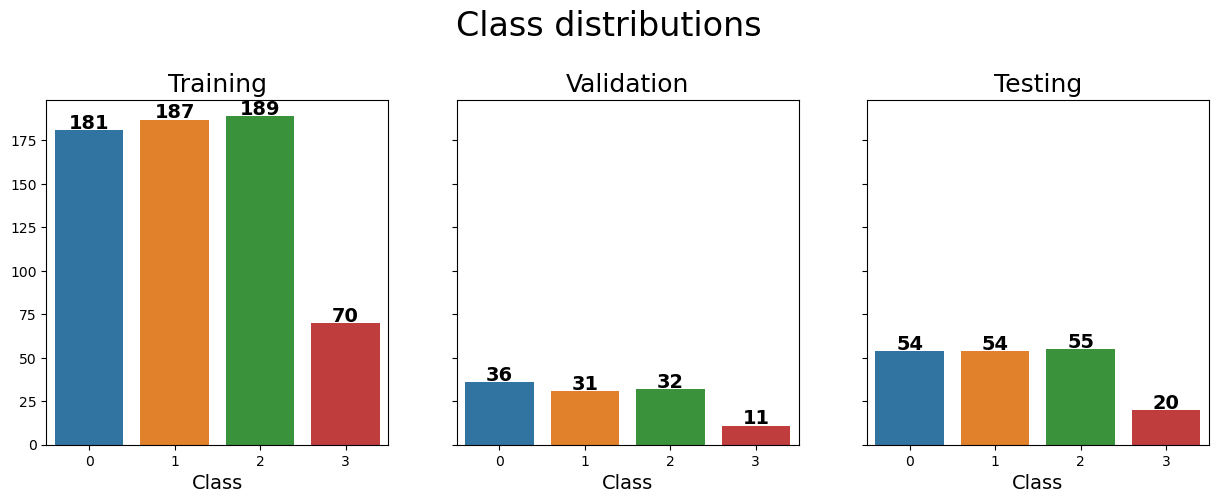

In [6]:
# Sample statistics
def class_check(subset):
    dataset_unbatched = tuple(subset.unbatch())
    labels = []
    for (image,label) in dataset_unbatched:
        labels.append(tf.argmax(label).numpy())
    labels = pd.Series(labels)
    return labels
def plot_class_distribution(data, title, ax):
    ax = sns.barplot(ax=ax, x=data.value_counts().index, y=data.value_counts())
    ax.set_title(title, fontsize=18)
    ax.set_xlabel('Class', fontsize=14)
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(height, (p.get_x() + p.get_width() / 2., height), ha='center', va='center', fontsize=14, color='black', xytext=(0, 5), textcoords='offset points', weight='bold')

train_labels = class_check(train_generator)
val_labels =  class_check(val_generator)
test_labels = class_check(test_generator) 

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Class distributions', fontsize=24)
plt.subplots_adjust(top=0.8)

plot_class_distribution(train_labels, 'Training', axes[0])
plot_class_distribution(val_labels, 'Validation', axes[1])
plot_class_distribution(test_labels, 'Testing', axes[2])
 
plt.show()

## The Model

### *Architecture*

In [7]:
input_shape=(224,224, 3)
 
final_model = Sequential()
#  # Add the preprocessing layers.  
final_model.add(layers.Rescaling(1./255, input_shape=input_shape))  
# #Conv layers
final_model.add(Conv2D(filters=16, kernel_size=3, activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Conv2D(filters=32, kernel_size=3, activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
final_model.add(MaxPooling2D(pool_size=(2, 2)))
final_model.add(Flatten())
#Dense   
final_model.add(Dense(units=128, activation='relu')) 
final_model.add(Dropout(0.5))
#Output layer
final_model.add(Dense(units=len(class_names), activation='softmax'))

# Compile the final model
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=tf.keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
              
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        1

  ### *Training model*

In [8]:
# Callbacks, model checkpointing
model_path = "tensorflow_garden_model.h5"  


In [9]:
callbacks = [
    ModelCheckpoint(
        model_path,
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
      ),
    EarlyStopping(
          monitor='val_loss', 
          patience=4,
          min_delta=1e-4,
          verbose=1
    ) 
]

# Train the model with checkpointing and early stopping 
history = final_model.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[callbacks])

Epoch 1/100
20/20 [==============================] - ETA: 0s - loss: 1.3125 - accuracy: 0.3525
Epoch 1: val_loss improved from inf to 1.18321, saving model to tensorflow_garden_model.h5
20/20 [==============================] - 22s 421ms/step - loss: 1.3125 - accuracy: 0.3525 - val_loss: 1.1832 - val_accuracy: 0.5909
Epoch 2/100
18/20 [==========================>...] - ETA: 0s - loss: 1.0715 - accuracy: 0.5851
Epoch 2: val_loss improved from 1.18321 to 0.94139, saving model to tensorflow_garden_model.h5
20/20 [==============================] - 14s 447ms/step - loss: 1.0580 - accuracy: 0.5949 - val_loss: 0.9414 - val_accuracy: 0.7273
Epoch 3/100
18/20 [==========================>...] - ETA: 0s - loss: 0.8917 - accuracy: 0.6528
Epoch 3: val_loss improved from 0.94139 to 0.85714, saving model to tensorflow_garden_model.h5
20/20 [==============================] - 13s 419ms/step - loss: 0.8967 - accuracy: 0.6491 - val_loss: 0.8571 - val_accuracy: 0.6545
Epoch 4/100
20/20 [===================

### *Visualizing training performance*

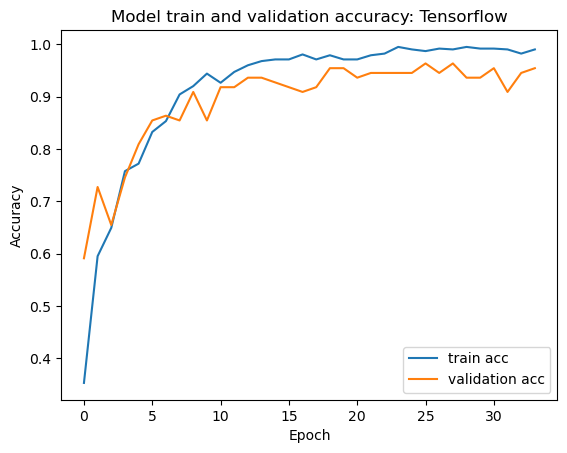

In [10]:
# Plotting accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy']) 
plt.title('Model train and validation accuracy: Tensorflow')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train acc', 'validation acc'])
plt.show()  

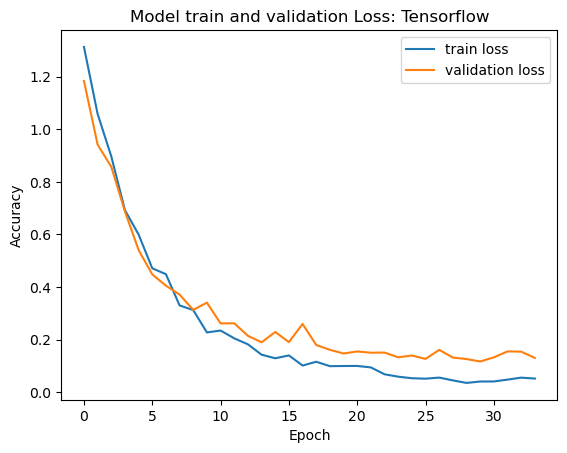

In [11]:
# Plotting accuracy curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss']) 
plt.title('Model train and validation Loss: Tensorflow')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

### *Evaluate the model on test data*

In [12]:
# Load the best model 
final_model.load_weights(model_path)
# Evaluate the model on the test set
test_loss, test_acc= final_model.evaluate(test_generator)
print('Test accuracy:', test_acc)

6/6 [==============================] - 3s 33ms/step - loss: 0.1828 - accuracy: 0.9563
Test accuracy: 0.9562841653823853


### *Visualizing testing performance*

In [13]:
# Get the true labels and predicted labels for the test set 
test_images = []
true_labels = []
pred_labels = []
predicted_probs = []

for image, label in test_generator.unbatch():
    test_images.append(image.numpy())
    true_labels.append(label.numpy())
    # Use the model to make predictions
    prediction = np.round(final_model.predict(np.expand_dims(image, axis=0), verbose=0)).astype(int) 
    pred_labels.append(np.round(prediction[0]).astype(int))
    predicted_probs.append(prediction[0][1])  # Assuming positive class is at index 1


# Convert the lists to numpy arrays
test_images = np.array(test_images)
true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)
predicted_probs = np.array(predicted_probs)
 
    
true_labels_binary = np.argmax(true_labels, axis=1)
pred_labels_binary = np.argmax(pred_labels, axis=1)

#Classification report
report = classification_report(true_labels_binary, pred_labels_binary, target_names=class_names)
# Print the classification report
print("Classification Report for CNN Model\n", report)

Classification Report for CNN Model
               precision    recall  f1-score   support

     Cassava       0.95      0.96      0.95        54
       Grass       0.96      0.98      0.97        54
       Maize       0.96      0.95      0.95        55
   Sugarcane       0.95      0.90      0.92        20

    accuracy                           0.96       183
   macro avg       0.95      0.95      0.95       183
weighted avg       0.96      0.96      0.96       183



[[52  0  1  1]
 [ 0 53  1  0]
 [ 1  2 52  0]
 [ 2  0  0 18]]


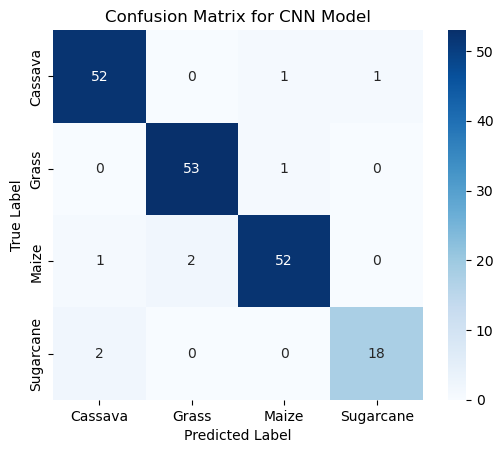

In [14]:
# Plot the confusion matrix 
conf_mat = confusion_matrix(true_labels_binary, pred_labels_binary)
print(conf_mat)
plt.imshow(conf_mat, cmap=plt.cm.Blues)
plt.title('Confusion Matrix for CNN Model')
sns.heatmap(conf_mat, annot=True,fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

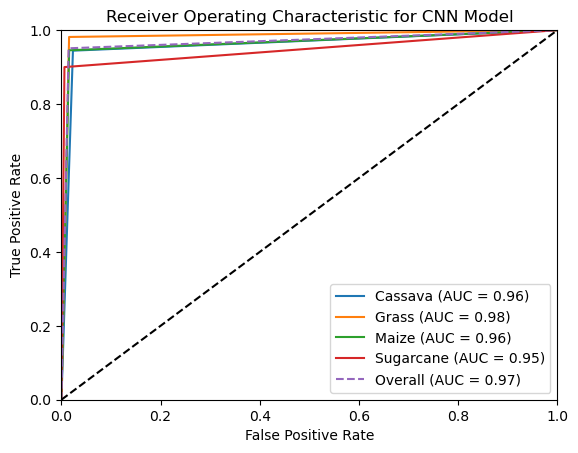

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
# Calculate the ROC curve and AUC for each label
fpr = dict()
tpr = dict()
auc_score = dict()
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(true_labels[:, i], pred_labels[:, i])
    auc_score[i] = auc(fpr[i], tpr[i])

# Calculate the overall AUC
overall_fpr, overall_tpr, _ = roc_curve(true_labels.ravel(), pred_labels.ravel())
overall_auc = auc(overall_fpr, overall_tpr)

# Plot the ROC curves
plt.figure()
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc_score[i]:.2f})')
plt.plot(overall_fpr, overall_tpr, label=f'Overall (AUC = {overall_auc:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for CNN Model')
plt.legend(loc='lower right')
plt.show()